[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1L13KuXs3lcMLL3k6OU8o1yXMiA_ONCaT?usp=sharing)

Submission by: Chiara Vega

Note: For Milestone 3, we are required to used LightGBM. Thankfully, I did this for Milestone 2.

# Introduction

The code in this notebook performs prediction on the Kaggle House Prices dataset using regression techniques.

I will be utilizing LightGBM to run my prediction tasks, Optuna for hyperparameter tuning, and SHAP to analyze and interpret the dataset features.

Link to the Kaggle dataset can be found here:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

# Installation

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 31.3 MB/s eta 0:00:00


In [2]:
!pip install Kaggle

# Download Kaggle Dataset

In [3]:
# Kaggle API credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kcpv24","key":"b93c3b11b4bb66b4cdec969cc0408490"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
# List of available Kaggle competitions
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        575           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-16 23:59:00  Analytics          $70,000        355           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       4607           False  
https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature                      2023-07-31 23:59:00  Research           $50,000    

In [6]:
# Download the House Prices competition dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 117MB/s]


In [7]:
# Unzip the downloaded dataset
!unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import Libraries and Load Dataset

In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import shap

import pickle

In [9]:
# Load train.csv and test.csv and print shapes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA

In [10]:
# Print shape of training and test data
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [11]:
# Display training data information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Target variable: SalePrice

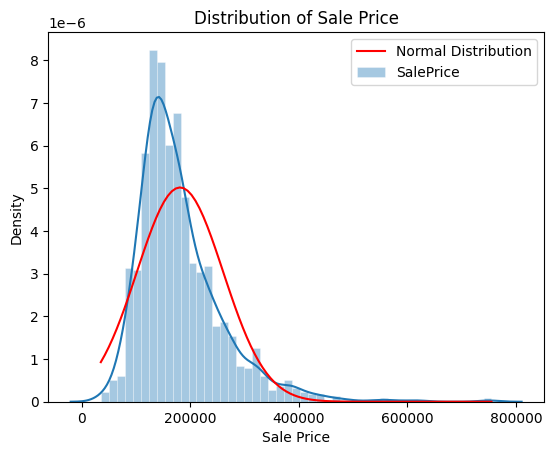

In [12]:
# Plot distribution of SalePrice
sns.histplot(df_train['SalePrice'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), label='SalePrice')

mu, sigma = df_train['SalePrice'].mean(), df_train['SalePrice'].std()
x = np.linspace(df_train['SalePrice'].min(), df_train['SalePrice'].max(), 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'r-', label='Normal Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Distribution of Sale Price')
plt.legend()
plt.show()

The distribution of SalePrice appears to be positive/right skewed.

In [13]:
# Display descriptive statistics
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [14]:
# Display the first few rows of the data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There appears to be NaNs. Let's see which features contain NaNs and NULLs.

In [15]:
# Identify features with NULL values
null_counts = df_train.isna().sum().sort_values(ascending=False)
null_columns = null_counts[null_counts > 0]

print("Columns with NULL values:")
for column, null_count in null_columns.items():
    print(f"{column:<15} {str(df_train[column].dtype):<12} {null_count}")

Columns with NULL values:
PoolQC          object       1453
MiscFeature     object       1406
Alley           object       1369
Fence           object       1179
FireplaceQu     object       690
LotFrontage     float64      259
GarageYrBlt     float64      81
GarageCond      object       81
GarageType      object       81
GarageFinish    object       81
GarageQual      object       81
BsmtFinType2    object       38
BsmtExposure    object       38
BsmtQual        object       37
BsmtCond        object       37
BsmtFinType1    object       37
MasVnrArea      float64      8
MasVnrType      object       8
Electrical      object       1


# Data Preprocessing

Recall that target SalePrice had a skewed distribution. In Milestone 2, I applied log transformation on SalePrice to reduce the variability and have the distribution approach a Normal distribution. However, I would like to skip this transformation step to view how well my model predicts the house sale price.

In [16]:
# No Logarithmic transformation for Milestone 3

# Logarithmic transformation of SalePrice
#df_train['SalePrice'] = np.log(df_train['SalePrice'])

# Plot the distribution of the transformed SalePrice
#sns.histplot(df_train['SalePrice'], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), label='SalePrice')

#mu, sigma = df_train['SalePrice'].mean(), df_train['SalePrice'].std()
#x = np.linspace(df_train['SalePrice'].min(), df_train['SalePrice'].max(), 100)
#y = norm.pdf(x, mu, sigma)

#plt.plot(x, y, 'r-', label='Normal Distribution')
#plt.xlabel('Sale Price')
#plt.ylabel('Density')
#plt.title('Distribution of Transformed Sale Price')
#plt.legend()
#plt.show()

Next, we move onto handling missing values and label encoding for categorical features.

In [17]:
# Handle missing values in the categorical and numerical features for both training and test data
for df in [df_train, df_test]:
  categorical_features = df.select_dtypes(include=['object']).columns
  numerical_features = df.select_dtypes(exclude=['object']).columns

  df[categorical_features] = df[categorical_features].fillna("missing")
  df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

  encoder = LabelEncoder()
  for column in categorical_features:
    df[column] = encoder.fit_transform(df[column])

In [18]:
# Check that there are no missing values
null_counts_train = df_train.isna().sum().sort_values(ascending=False)
null_counts_train = null_counts_train[null_counts_train > 0]
print(null_counts_train)

null_counts_test = df_test.isna().sum().sort_values(ascending=False)
null_counts_test = null_counts_test[null_counts_test > 0]
print(null_counts_test)

Series([], dtype: int64)
Series([], dtype: int64)


In [19]:
# Check that the categorical features have been transformed in training data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000


In [20]:
# Check that the categorical features have been transformed in test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2,80.0,11622,1,2,3,3,0,...,120,0,2,2,3,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,2,0,3,0,...,0,0,2,4,0,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,2,0,3,0,...,0,0,2,2,3,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,2,0,3,0,...,0,0,2,4,3,0,6,2010,8,4
4,1465,120,3,43.0,5005,1,2,0,1,0,...,144,0,2,4,3,0,1,2010,8,4


# Baseline

## Training LightGBM

I will be using LGBMRegressor. As stated before the Introduction, only LightGBM is required for Milestone 3. I have confirmed this with the professor on Discord.

In [21]:
# Set X, y for training and test data
X_train = df_train.drop(['SalePrice'], axis=1)
y_train = df_train["SalePrice"]

X_test = df_test # will be used to print prediction

In [22]:
# Split the training data into training and validation sets
random_state = 123
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)

In [23]:
# Define function for cross-validation with cv=5
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

In [25]:
# Train the LightGBM model
LGBMR = LGBMRegressor(random_state=random_state)
LGBMR.fit(X_train, y_train)

y_pred_lgbm = LGBMR.predict(X_val)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
score_lgbm = LGBMR.score(X_val, y_val)
cv_lgbm = mean_cross_val(LGBMR, X_train, y_train)

# Train the XGBoost model
#XGBR = XGBRegressor(seed=random_state)
#XGBR.fit(X_train, y_train)

#y_pred_xgb = XGBR.predict(X_val)
#rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
#score_xgb = XGBR.score(X_val, y_val)
#cv_xgb = mean_cross_val(XGBR, X_train, y_train)

## Evaluation

In [26]:
# Create a table to compare the models performances
table = pd.DataFrame({
    "Model": ["LightGBM"],#, "XGBoost"],
    "CV=5": [cv_lgbm],#, cv_xgb],
    "R\u00b2": [score_lgbm],#, score_xgb],
    "MSE": [rmse_lgbm],#, rmse_xgb]
})
styled_table = table.style.set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
styled_table

,Model,CV=5,R²,MSE
0,LightGBM,0.837389,0.881649,26060.542861


## Model Predictions

In [28]:
# Preview the LGBMRegressor predicted values for the test data using the trained models
lgbm_pred = LGBMR.predict(X_test).round().astype(int)

lgbm_prediction = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': lgbm_pred})
print(f"LGBMRegressor Prediction:\n")
lgbm_prediction.head()

LGBMRegressor Prediction:



,Id,SalePrice
0,1461,132222
1,1462,159017
2,1463,179610
3,1464,184152
4,1465,180136


In [29]:
# Preview the XGBRegressor predicted values for the test data using the trained models
#xgb_pred = XGBR.predict(X_test)
#xgb_pred = np.exp(xgb_pred).round().astype(int)

#xgb_prediction = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': xgb_pred})
#print(f"XGBRegressor Prediction:\n")
#xgb_prediction.head()

## Model Explainability with SHAP

Now, let's see if we can use SHAP to explain the trained models.

In [30]:
# Get SHAP values and SHAP interaction values for the trained LightGBM and XGBoost models
explainer_LGBM = shap.TreeExplainer(LGBMR)
shap_LGBM = explainer_LGBM(X_train)
shap_values_LGBM = explainer_LGBM.shap_values(X_train)
shap_interaction_values_LGBM = explainer_LGBM.shap_interaction_values(X_train)

#explainer_XGB = shap.TreeExplainer(XGBR)
#shap_XGB = explainer_XGB(X_train)
#shap_values_XGB = explainer_XGB.shap_values(X_train)
#shap_interaction_values_XGB = explainer_XGB.shap_interaction_values(X_train)

### Global Interpretability

#### Bar Plots

Below you will find the 2 different types of bar plots that could be printed in SHAP. The bar plots function as feature importance plots for the LightGBM model. On the left-hand side, you will find the features sorted from top to bottom by impact level where the most influential feature is located at the top. The ranking is determined by their (the features) mean absolute SHAP values - the average magnitude of each feature's impact on the model's predicted house "SalePrice" across all instances. In this case, this most impactful feature is "OverallQual", which is unsurprising as I resasonably expect that the overall quality of a house could have a significant impact on the sales price of the house in question.

The LightGBM model lists "OverallQual", "GrLivArea", and "TotalBsmtSF" as the top 3 influential features.

LGBMRegressor:


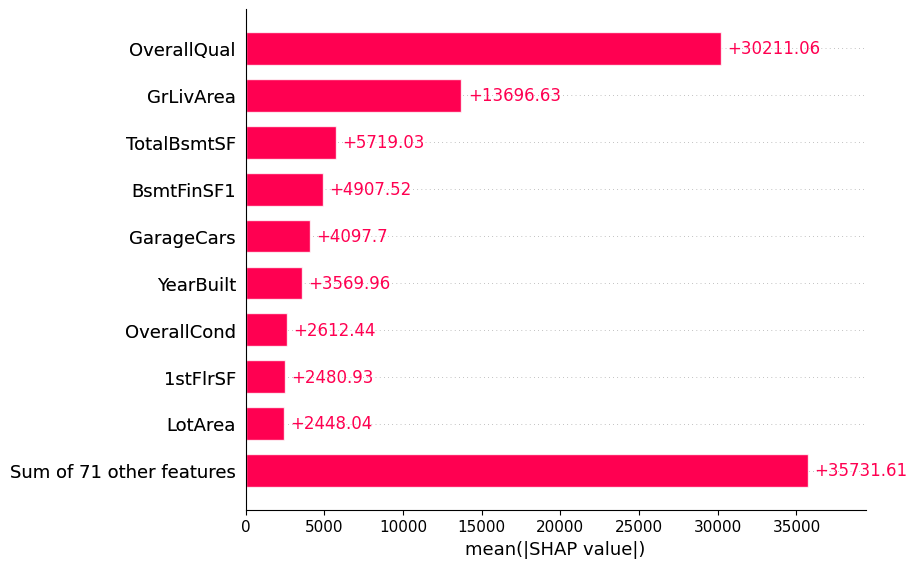

In [31]:
# Plot
print(f"LGBMRegressor:")
shap.plots.bar(shap_LGBM, max_display=10)
#print()
#print(f"XGBRegressor:")
#shap.plots.bar(shap_XGB, max_display=10)

LGBMRegressor:


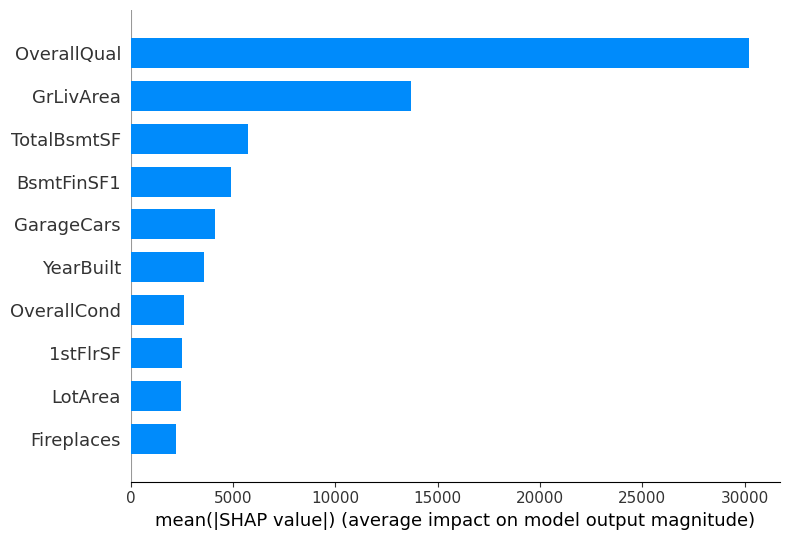

In [32]:
print(f"LGBMRegressor:")
shap.summary_plot(shap_LGBM, plot_type='bar', max_display=10)
#print()
#print(f"XGBRegressor:")
#shap.summary_plot(shap_XGB, plot_type='bar', max_display=10)

#### Beeswarm Plots

Similar to the bar plot is a below beeswarm plot. Again, you will find feature importance ordered by most impactful feature down to least influential by SHAP value. However, beeswarm plots are able to illustrate more information of the SHAP values as they not only reveal the relative feature importance, but also the relationships with the model's prediction. Each point is a SHAP value that is distributed horizontally according to their respective SHAP values and stacked vertically showing density of the SHAP values. Each of the points are assigned a color corresponding to the raw values of the features where red indicates a high feature value and blue a low feature value. With the examination of the color distribution, insights can be made of each feature's directionality impact - the general relationship between the feature's raw values and its SHAP values.

In the case of "OverallQual", the feature with the highest impact, a higher overall quality value leads to positive SHAP values indicating that houses with high overall quality have higher sales prices predicted.

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


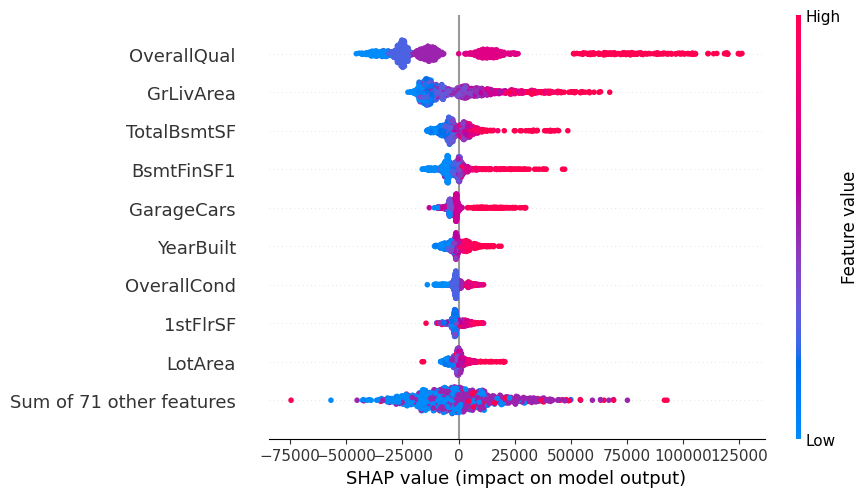

In [33]:
print(f"LGBMRegressor:")
shap.plots.beeswarm(shap_LGBM, max_display=10)
#print()
#print(f"XGBRegressor:")
#shap.plots.beeswarm(shap_XGB, max_display=10)

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


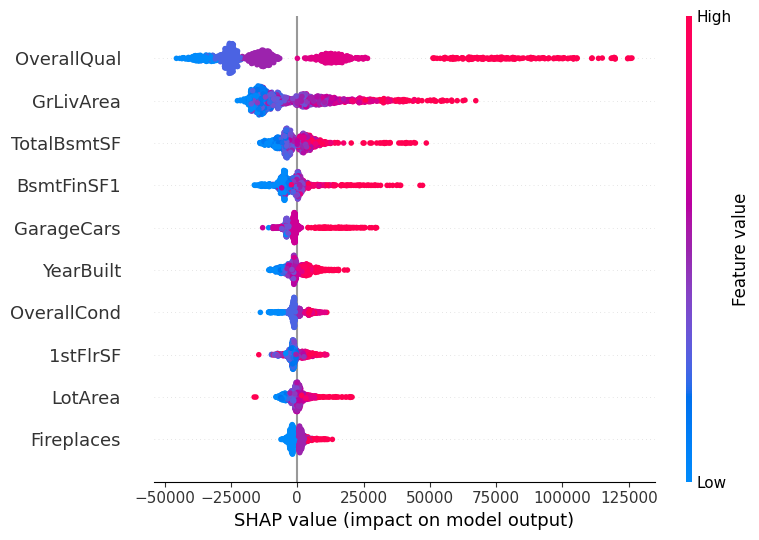

In [34]:
print(f"LGBMRegressor:")
shap.summary_plot(shap_LGBM, max_display=10)
#print()
#print(f"XGBRegressor:")
#shap.summary_plot(shap_XGB, max_display=10)

### Local Interpretability

#### Waterfall Plots

Waterfall plots are great visualizations in that they are able to provide a more detailed breakdown of each feature's contribution towards the prediction of the house "SalePrice". The waterfall structure places emphasis on the additive nature of the positive and negative impacts built on the base value $E[f(X)]$ (the expected value of the house sales price model output) for yielding the specified model's prediction $f(X)$. In other words, each feature shows how the positive (red) or negative (blue) contribution moves the values from the expected model output over the dataset to the model prediction output.

For LightGBM, the top contributer, "OverallQual", is pushing the prediction of the sales price to be low, could make sense as the year is stated to be 1996 and the overall quality is 5.

LGBMRegressor:


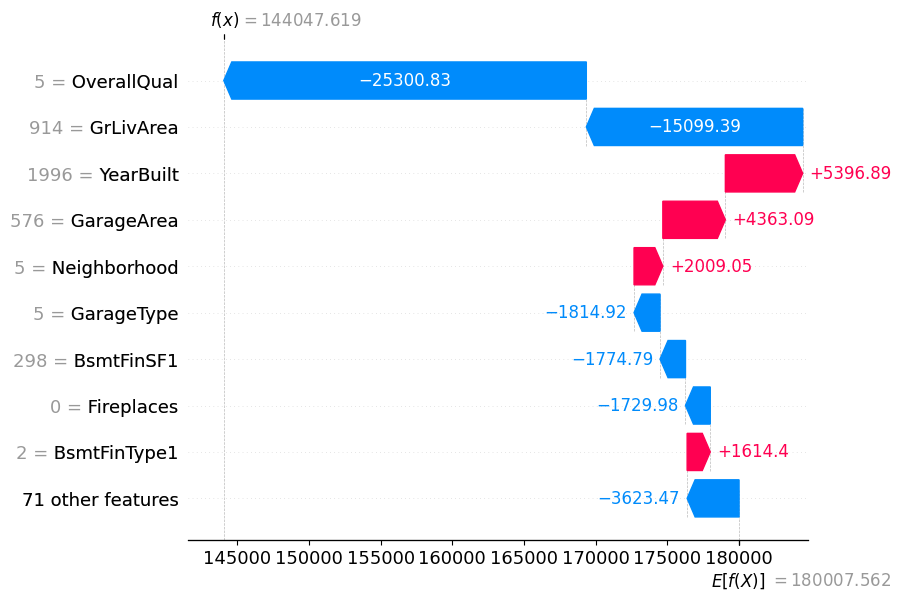

In [35]:
print(f"LGBMRegressor:")
shap.plots.waterfall(shap_LGBM[0], max_display=10)
#print()
#print(f"XGBRegressor:")
#shap.plots.waterfall(shap_XGB[0], max_display=10)

#### Force Plots

Similar to the waterfall plots, the force plots also display just how much each feature "pushes" the model towards a higher or lower "SalePrice", but in a condensed format. As stated in the previous section for the waterfall plots, LightGBM's top contributing feature "OverallQual" is the feature that pushes to a lower predicted house sales price.

In [36]:
print(f"LGBMRegressor:")
shap.initjs()
shap.plots.force(shap_LGBM[0])

LGBMRegressor:


In [37]:
#print(f"XGBRegressor:")
#shap.initjs()
#shap.plots.force(shap_XGB[0])

### SHAP Interaction Values

Below I plotted the interaction effects between features SHAP values. I chose the top 5 features that contributed the most to the specified model's prediction (according to the bar plots). In the first plot for LightGBM, for example, you can see the interaction effects of "OverallQual" and "GrLivArea" features.

LGBMRegressor:


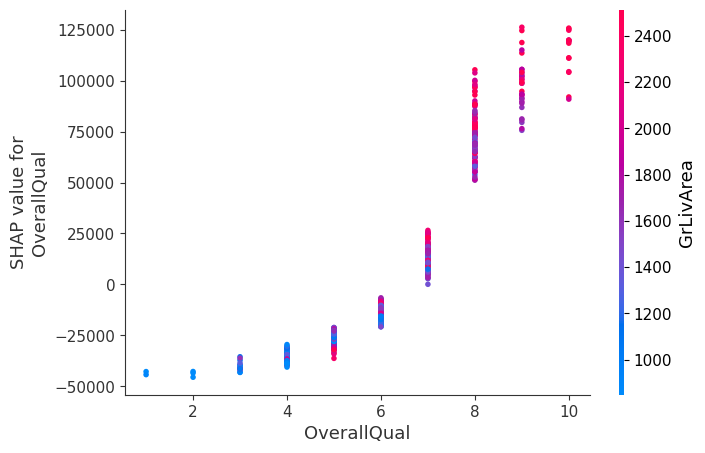

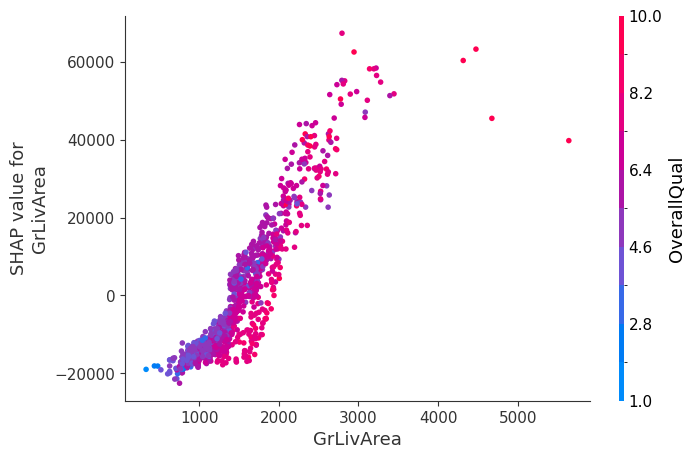

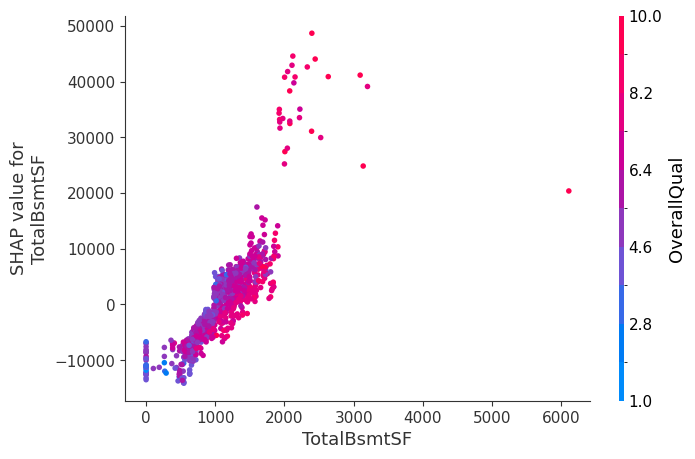

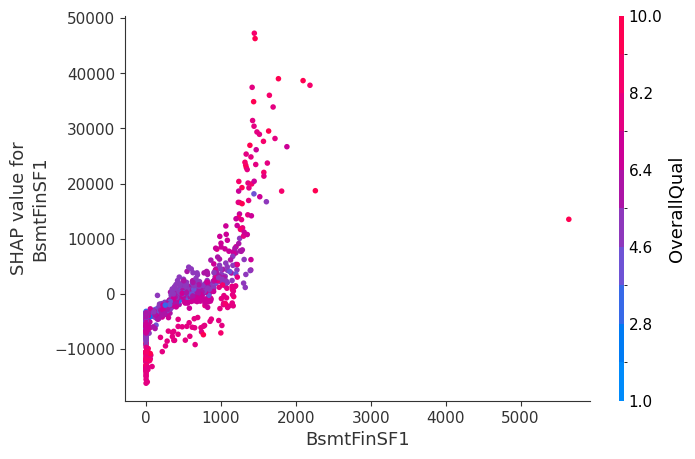

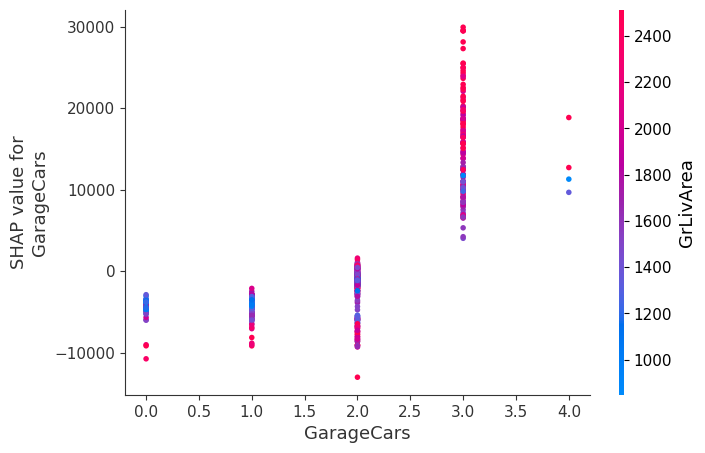

In [41]:
# Top 5 features as illustrated from the bar plots
print("LGBMRegressor:")
shap.dependence_plot("OverallQual", shap_values_LGBM, X_train)
print()
shap.dependence_plot("GrLivArea", shap_values_LGBM, X_train)
print()
shap.dependence_plot("TotalBsmtSF", shap_values_LGBM, X_train)
print()
shap.dependence_plot("BsmtFinSF1", shap_values_LGBM, X_train)
print()
shap.dependence_plot("GarageCars", shap_values_LGBM, X_train)

In [39]:
#print("XGBRegressor")
#shap.dependence_plot("OverallQual", shap_values_XGB, X_train)
#print()
#shap.dependence_plot("GrLivArea", shap_values_XGB, X_train)
#print()
#shap.dependence_plot("TotalBsmtSF", shap_values_XGB, X_train)
#print()
#shap.dependence_plot("GarageCars", shap_values_XGB, X_train)
#print()
#shap.dependence_plot("GarageType", shap_values_XGB, X_train)

Below is a plot that appears almost similarly in the form of a Correlation Matrix. This is more of an overview of feature importances along with their interactions with other features.

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


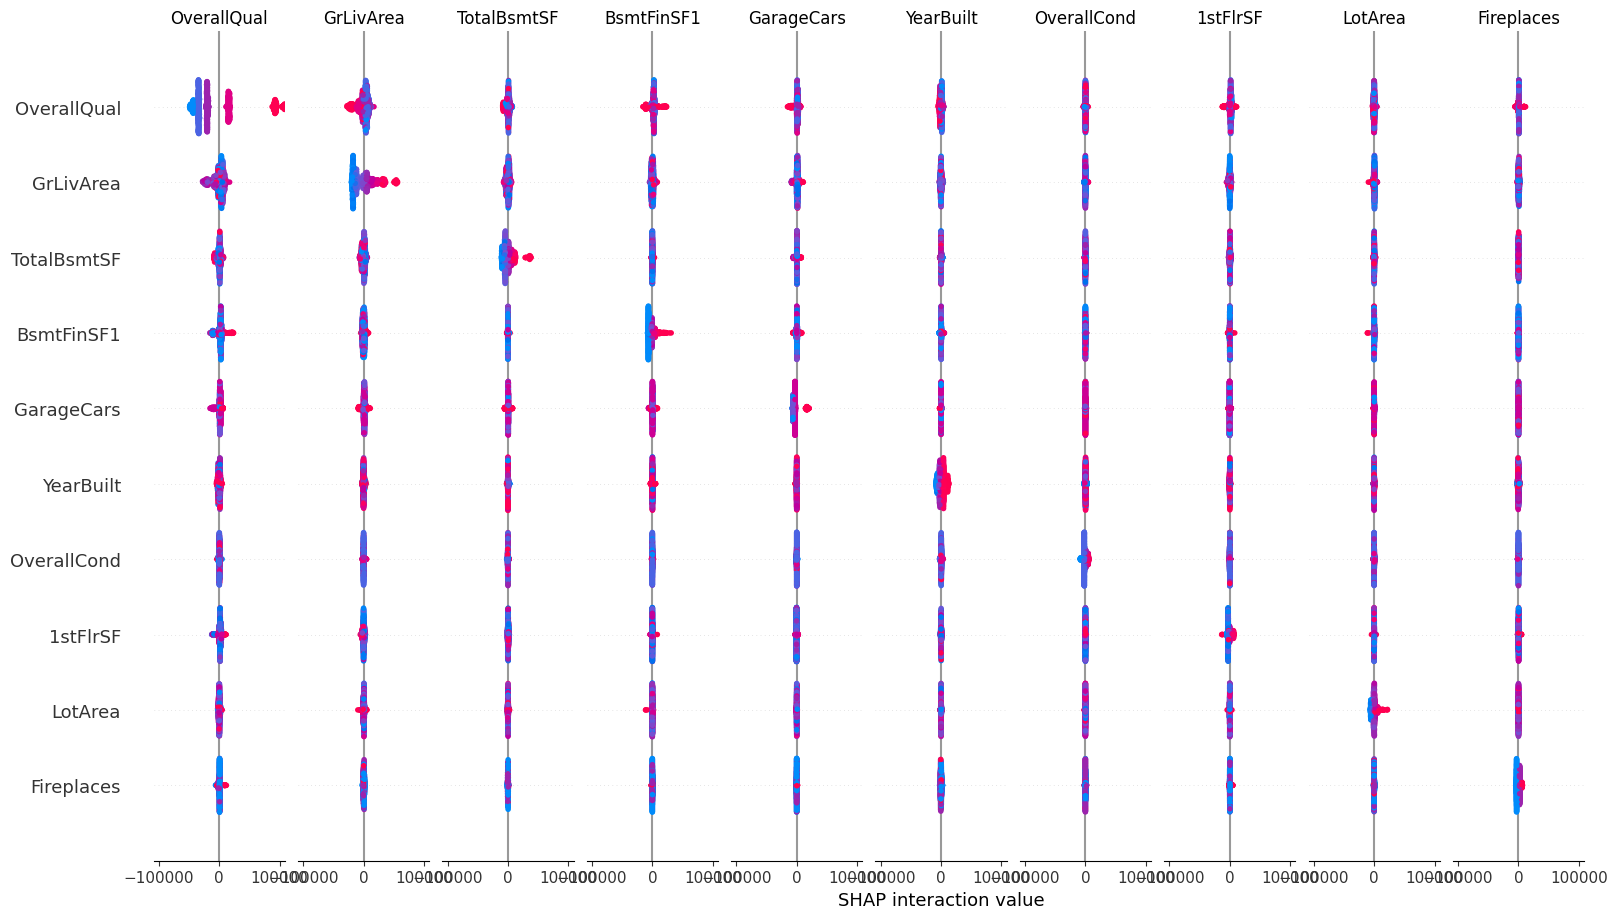

In [40]:
print("LGBMRegressor:")
shap.summary_plot(shap_interaction_values_LGBM, X_train, max_display=10)
#print()
#print("XGBRegressor")
#shap.summary_plot(shap_interaction_values_XGB, X_train, max_display=10)

# Hyperparameter Optimization via Tuning with Optuna

The results for our baseline model appeared to be relatively decent. Let's see if the model can be improved by tuning the hyperparameters via Optuna, which is a powerful framework for hyperparameter optimization. Optuna offers an automated and efficient approach to search for the ideal hyperparameters. More specifically, it makes use of a Bayesian optimization algorithm called Tree-structured Parzen Estimator.

In [42]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


In [43]:
import optuna

Note: I understand that, for Milestone 3, only LightGBM should be run. However, my first attempt at completing Milestone 3 included XGBoost. Interestingly, when I'd compared both models, I found that XGBoost performed better in both $R^2$ and RMSE scores than LightGBM.

In [44]:
# Define the objective function for Optuna
def objective_lgbm(trial):
    # Define the hyperparameter search space
    params_lgbm = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    # Train the LGBMRegressor model with the current hyperparameters
    LGBMR_opt = LGBMRegressor(**params_lgbm, random_state=random_state)
    LGBMR_opt.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred_lgbm_opt = LGBMR_opt.predict(X_val)
    rmse_lgbm_opt = mean_squared_error(y_val, y_pred_lgbm_opt, squared=False)

    return rmse_lgbm_opt

# Create an Optuna study and optimize the objective function
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=101)

# Get the best hyperparameters and retrain the model
best_params_lgbm = study_lgbm.best_params
LGBMR_best = LGBMRegressor(**best_params_lgbm, random_state=random_state)
LGBMR_best.fit(X_train, y_train)

y_pred_lgbm_best = LGBMR_best.predict(X_val)
rmse_lgbm_best = mean_squared_error(y_val, y_pred_lgbm_best, squared=False)
score_lgbm_best = LGBMR_best.score(X_val, y_val)
cv_lgbm_best = mean_cross_val(LGBMR_best, X_train, y_train)

# Define the objective function for Optuna
#def objective_xgb(trial):
    # Define the hyperparameter search space
#    params_xgb = {
#        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 10),
#        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#    }

    # Train the XGBRegressor model with the current hyperparameters
#    XGBR_opt = XGBRegressor(**params_xgb, random_state=random_state)
#    XGBR_opt.fit(X_train, y_train)

    # Evaluate the model on the validation set
#    y_pred_xgb_opt = XGBR_opt.predict(X_val)
#    rmse_xgb_opt = mean_squared_error(y_val, y_pred_xgb_opt, squared=False)

#    return rmse_xgb_opt

# Create an Optuna study and optimize the objective function
#study_xgb = optuna.create_study(direction='minimize')
#study_xgb.optimize(objective_xgb, n_trials=101)

# Get the best hyperparameters and retrain the model
#best_params_xgb = study_xgb.best_params
#XGBR_best = XGBRegressor(**best_params_xgb, random_state=random_state)
#XGBR_best.fit(X_train, y_train)

#y_pred_xgb_best = XGBR_best.predict(X_val)
#rmse_xgb_best = mean_squared_error(y_val, y_pred_xgb_best, squared=False)
#score_xgb_best = XGBR_best.score(X_val, y_val)
#cv_xgb_best = mean_cross_val(XGBR_best, X_train, y_train)

[I 2023-07-07 21:17:44,994] A new study created in memory with name: no-name-d4e6772a-7260-4982-8e08-db11babb69dc
[I 2023-07-07 21:17:45,981] Trial 0 finished with value: 24171.813777715903 and parameters: {'n_estimators': 950, 'learning_rate': 0.028176965528623157, 'max_depth': 7, 'num_leaves': 46, 'min_child_samples': 6, 'subsample': 0.9149345297025785, 'colsample_bytree': 0.6368909952393867}. Best is trial 0 with value: 24171.813777715903.
[I 2023-07-07 21:17:46,139] Trial 1 finished with value: 25047.0584598359 and parameters: {'n_estimators': 201, 'learning_rate': 0.07988842549381694, 'max_depth': 8, 'num_leaves': 12, 'min_child_samples': 15, 'subsample': 0.6483873591292982, 'colsample_bytree': 0.5240362120753932}. Best is trial 0 with value: 24171.813777715903.
[I 2023-07-07 21:17:46,910] Trial 2 finished with value: 25387.110864619295 and parameters: {'n_estimators': 295, 'learning_rate': 0.040445871395284716, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 1, 'subsample

## Evaluation

In [45]:
# Print best hyperparameters for the 2 models
print(f"Best Hyperparameters for LGBMRrgressor:\n {best_params_lgbm}")
#print(f"\nBest Hyperparameters for XGBRegressor:\n {best_params_xgb}")

Best Hyperparameters for LGBMRrgressor:
 {'n_estimators': 682, 'learning_rate': 0.02604550764322017, 'max_depth': 3, 'num_leaves': 14, 'min_child_samples': 2, 'subsample': 0.9550193851297658, 'colsample_bytree': 0.6451459068553724}


In [46]:
# Create a table to compare the models performances
table_best = pd.DataFrame({
    "Model": ["LightGBM", "LightGBM with Optuna"],#, "XGBoost", "XGBoost with Optuna"],
    "CV=5": [cv_lgbm, cv_lgbm_best],#, cv_xgb, cv_xgb_best],
    "R\u00b2": [score_lgbm, score_lgbm_best],#, score_xgb, score_xgb_best],
    "RMSE": [rmse_lgbm, rmse_lgbm_best],#, rmse_xgb, rmse_xgb_best]
})
styled_table_best = table_best.style.set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
styled_table_best

,Model,CV=5,R²,RMSE
0,LightGBM,0.837389,0.881649,26060.542861
1,LightGBM with Optuna,0.861405,0.907733,23010.183061


Great to see that by implementing hyperparameter tuning with Optuna, the cross-validation, $R^2$ and RMSE scores for the LightGBM model have improved.

## Prediction

In [47]:
# Preview the LGBMRegressor predicted values for the test data using the trained models
lgbm_pred_best = LGBMR_best.predict(X_test).round().astype(int)

lgbm_prediction_best = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': lgbm_pred_best})
print(f"LGBMRegressor with Optuna Prediction:\n")
lgbm_prediction_best.head()

LGBMRegressor with Optuna Prediction:



,Id,SalePrice
0,1461,127852
1,1462,160429
2,1463,174474
3,1464,178538
4,1465,191691


In [48]:
# Preview the XGBRegressor predicted values for the test data using the trained models
#xgb_pred_best = XGBR_best.predict(X_test)
#xgb_pred_best = xgb_pred_best.round().astype(int)

#xgb_prediction_best = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': xgb_pred_best})
#print(f"XGBRegressor with Optuna Prediction:\n")
#xgb_prediction_best.head()

## SHAP for Optimized LightGBM

In [49]:
# Get SHAP values and SHAP interaction values for the trained LightGBM and XGBoost models
explainer_LGBM_best = shap.TreeExplainer(LGBMR_best)
shap_LGBM_best = explainer_LGBM_best(X_train)
shap_values_LGBM_best = explainer_LGBM_best.shap_values(X_train)
shap_interaction_values_LGBM_best = explainer_LGBM_best.shap_interaction_values(X_train)

### Global

A change has happened in the rankings, especially the top 5 features. Feature "GarageType" has now replaced feature "GarageCars" for the 5th position.

LGBMRegressor:


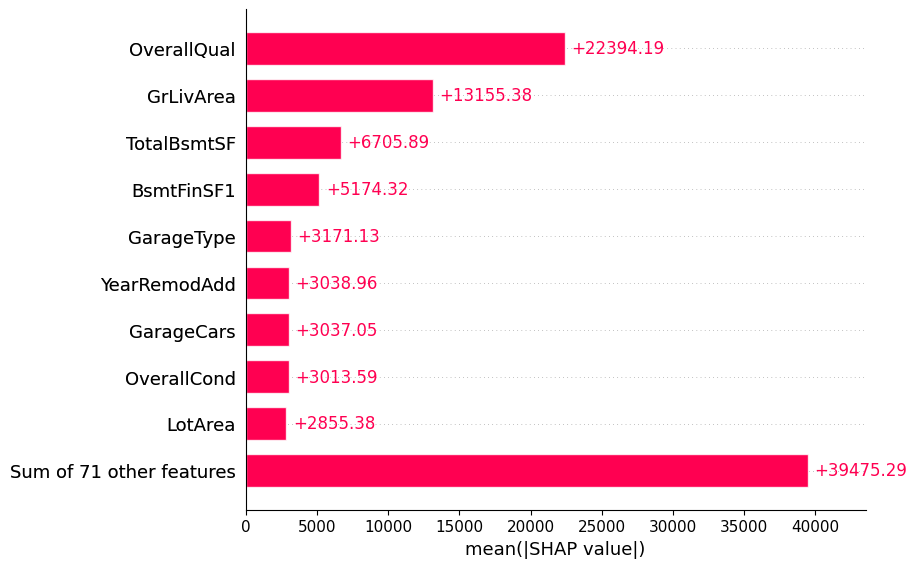

In [50]:
print(f"LGBMRegressor:")
shap.plots.bar(shap_LGBM_best, max_display=10)

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


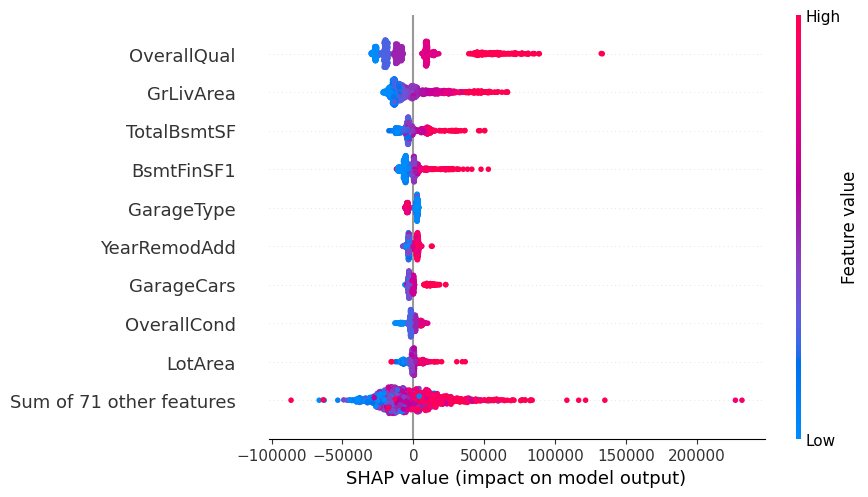

In [51]:
print(f"LGBMRegressor:")
shap.plots.beeswarm(shap_LGBM_best, max_display=10)

### Local

LGBMRegressor:


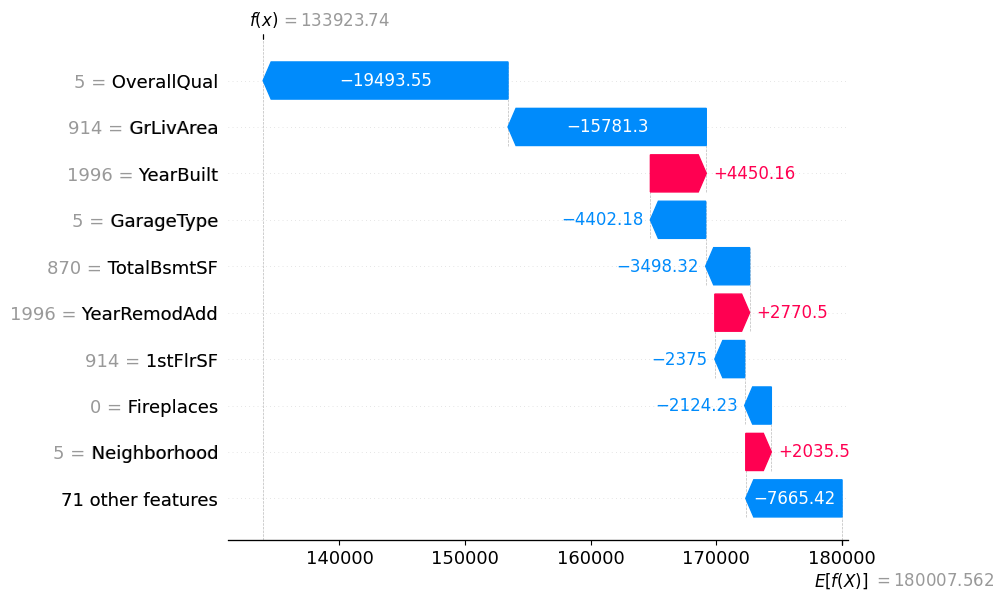

In [52]:
print(f"LGBMRegressor:")
shap.plots.waterfall(shap_LGBM_best[0], max_display=10)

In [53]:
print(f"LGBMRegressor:")
shap.initjs()
shap.plots.force(shap_LGBM_best[0])

LGBMRegressor:


### SHAP Interaction Plots

LGBMRegressor:


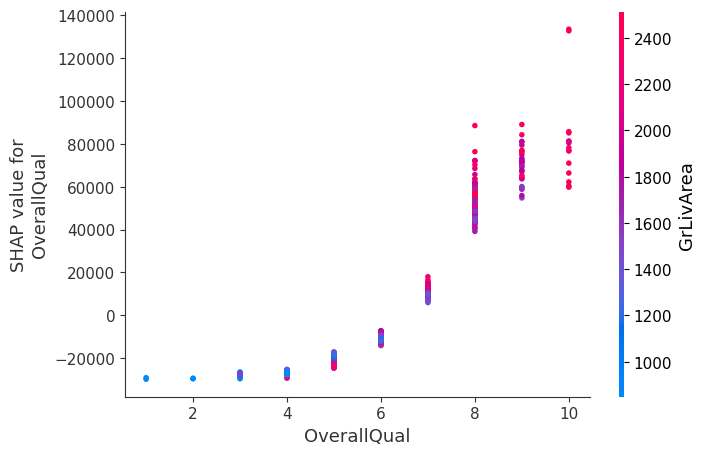

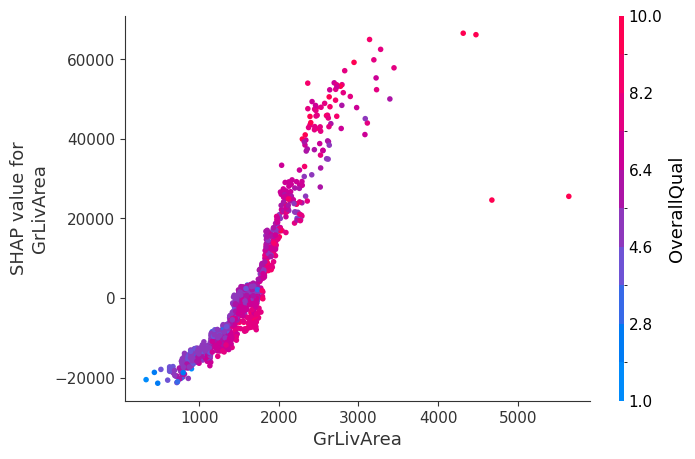

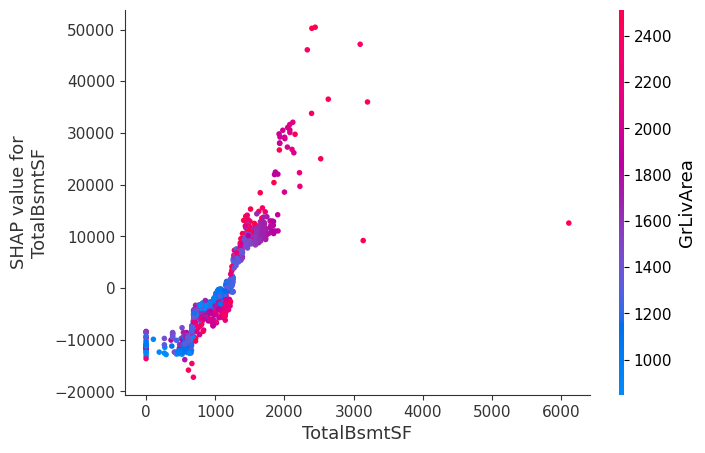

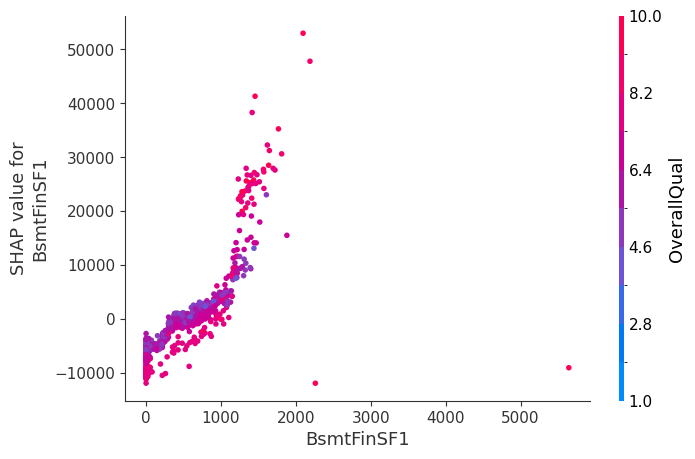

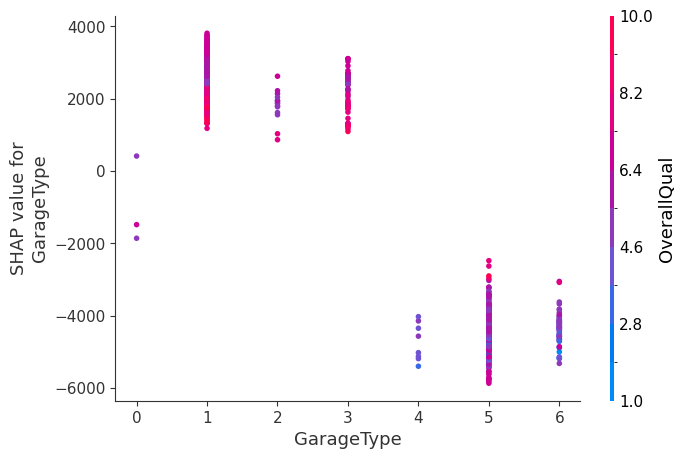

In [56]:
# Top 5
print("LGBMRegressor:")
shap.dependence_plot("OverallQual", shap_values_LGBM_best, X_train)
print()
shap.dependence_plot("GrLivArea", shap_values_LGBM_best, X_train)
print()
shap.dependence_plot("TotalBsmtSF", shap_values_LGBM_best, X_train)
print()
shap.dependence_plot("BsmtFinSF1", shap_values_LGBM_best, X_train)
print()
shap.dependence_plot("GarageType", shap_values_LGBM_best, X_train)

LGBMRegressor:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


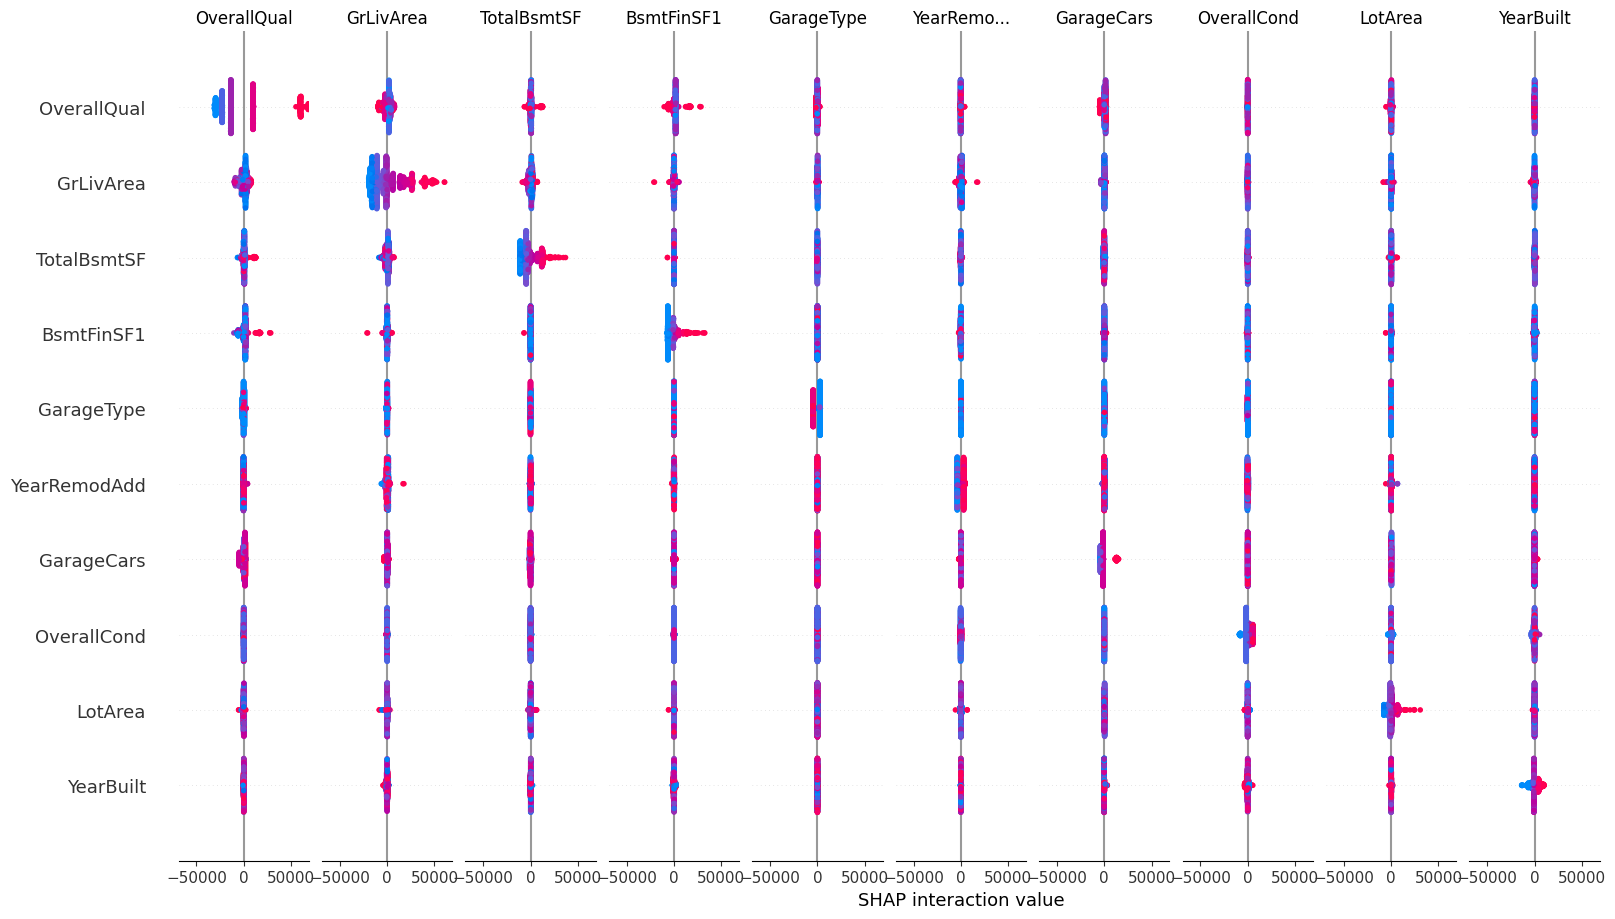

In [55]:
print("LGBMRegressor:")
shap.summary_plot(shap_interaction_values_LGBM_best, X_train, max_display=10)

# Prepare for HuggingFace Streamlit App

The HuggingFace streamlit app that I will be creating references the following user's app:

https://github.com/adhok/streamlit_ames_housing_price_prediction_app

In [59]:
# Select features to use for HuggingFace Streamlit App
selected_features =  ['OverallQual', 'OverallCond', 'YrSold', 'YearBuilt', 'YearRemodAdd',
                   'LotArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GrLivArea',
                   'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
                   'GarageYrBlt', 'GarageArea', 'PoolArea'
]

In [60]:
# Set X, y for training and test data for HuggingFace Streamlit App
X_train1 = X_train[selected_features]
X_val1 = X_val[selected_features]

X_test1 = X_test[selected_features] # will be used to print prediction

In [61]:
# Baseline LightGBM model
LGBMR_HF = LGBMR
LGBMR_HF.fit(X_train1, y_train)

y_pred_hf = LGBMR_HF.predict(X_val1)
rmse_hf = mean_squared_error(y_val, y_pred_hf, squared=False)
score_hf = LGBMR_HF.score(X_val1, y_val)
cv_hf = mean_cross_val(LGBMR_HF, X_train1, y_train)

# LightGBM model tuned with Optuna
LGBMR_best_HF = LGBMR_best
LGBMR_best_HF.fit(X_train1, y_train)

y_pred_best_hf = LGBMR_best_HF.predict(X_val1)
rmse_best_hf = mean_squared_error(y_val, y_pred_best_hf, squared=False)
score_best_hf = LGBMR_best_HF.score(X_val1, y_val)
cv_best_hf = mean_cross_val(LGBMR_best_HF, X_train1, y_train)

In [62]:
# Create a table to compare the models performances
table_best = pd.DataFrame({
    "Model": ["LightGBM", "LightGBM with Optuna"],#, "XGBoost", "XGBoost with Optuna"],
    "CV=5": [cv_hf, cv_best_hf],#, cv_xgb, cv_xgb_best],
    "R\u00b2": [score_hf, score_best_hf],#, score_xgb, score_xgb_best],
    "RMSE": [rmse_hf, rmse_best_hf],#, rmse_xgb, rmse_xgb_best]
})
styled_table_best = table_best.style.set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
styled_table_best

,Model,CV=5,R²,RMSE
0,LightGBM,0.824052,0.872202,27080.689318
1,LightGBM with Optuna,0.804900,0.906749,23132.634780


In [63]:
# Preview the LGBMRegressor predicted values for the test data using the trained models
lgbm_pred_hf = LGBMR_HF.predict(X_test1).round().astype(int)

lgbm_prediction_hf = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': lgbm_pred_hf})
print(f"LGBMRegressor with Optuna Prediction:\n")
lgbm_prediction_hf.head()

LGBMRegressor with Optuna Prediction:



,Id,SalePrice
0,1461,123619
1,1462,150707
2,1463,169503
3,1464,188594
4,1465,178869


In [64]:
# Preview the LGBMRegressor (tuned) predicted values for the test data using the trained models
lgbm_pred_best_hf = LGBMR_best_HF.predict(X_test1).round().astype(int)

lgbm_prediction_best_hf = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': lgbm_pred_best_hf})
print(f"LGBMRegressor with Optuna Prediction:\n")
lgbm_prediction_best_hf.head()

LGBMRegressor with Optuna Prediction:



,Id,SalePrice
0,1461,122561
1,1462,156715
2,1463,173010
3,1464,184918
4,1465,181433


In [69]:
# Save LightGBM baseline model
pickle.dump(LGBMR_HF, open('lgbm_base.pkl', 'wb'))

# Save LightGBM model tuned via Optuna
pickle.dump(LGBMR_best_HF, open('lgbm_opt.pkl', 'wb'))

In [70]:
# Download the .pkl files
files.download('lgbm_base.pkl')
files.download('lgbm_opt.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>